## Import

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import torch

In [4]:
# https://www.kaggle.com/datasets/benhamner/sf-bay-area-bike-share?select=status.csv
dataset_station_statut = pd.read_csv("../../../../Bike_Data/status.csv")
dataset_station = pd.read_csv("../../../../Bike_Data/station.csv")

## Class TimeSeriesDataset

In [6]:
# Define a PyTorch dataset to generate input/target pairs for the LSTM model
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, stride, target_size=1, drop=None):
        self.data = data
        self.window_size = window_size
        self.stride = stride
        self.target_size = target_size
        self.drop = drop

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        inputs = self.data[idx:idx+self.window_size]
        target = self.data[idx+self.window_size:idx+self.window_size+self.target_size]
        if self.drop is not None:
            target = np.delete(target, self.drop, axis=1)
        return inputs, target

## Class LSTM v1

In [7]:
# Define your LSTM model here with num_layers LSTM layers and 1 fully connected layer
class LSTMModel_v1(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = torch.nn.LSTM(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = torch.nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## Station statut dataset

## Station dataset

In [8]:
dataset_station.head(3)

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013


In [9]:
dataset_station.shape

(70, 7)

## Merge dataset Station statut and Station

In [10]:
dataset = pd.merge(dataset_station, dataset_station_statut, left_on='id', right_on='station_id')

In [11]:
dataset.head(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:06:01
1,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:07:01
2,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:08:01


In [12]:
dataset.shape

(71984434, 11)

### See the mean variation for differents interval of time

In [80]:
dataset_station_statut_drop = dataset_station_statut.drop(["docks_available"], axis=1)
dataset_station_statut_drop['time'] = pd.to_datetime(dataset_station_statut_drop['time'], format="mixed")
pivoted_dataset_station_statut_drop = dataset_station_statut_drop.pivot_table(index='time', columns='station_id', values='bikes_available')

In [81]:
import pandas as pd

# assuming your dataframe is named df and has a datetime index
intervals = ['5min', '10min', '15min', '30min', '60min']
for interval in intervals:
    resampled = pivoted_dataset_station_statut_drop.resample(interval).var().mean().sort_values(ascending=False)
    print(f'Mean Variance for {interval} interval:')
    print(resampled)

Mean Variance for 5min interval:
station_id
70    0.227252
69    0.152443
50    0.144004
61    0.110123
60    0.104654
        ...   
33    0.006550
8     0.006083
23    0.005957
38    0.005068
5     0.004799
Length: 70, dtype: float64
Mean Variance for 10min interval:
station_id
70    0.500550
69    0.343188
50    0.317341
61    0.233667
60    0.210250
        ...   
8     0.011556
33    0.010267
5     0.008726
23    0.008316
38    0.007830
Length: 70, dtype: float64
Mean Variance for 15min interval:
station_id
70    0.783799
69    0.557002
50    0.492731
61    0.346430
65    0.325293
        ...   
8     0.016246
33    0.013776
5     0.012483
38    0.010602
23    0.010149
Length: 70, dtype: float64
Mean Variance for 30min interval:
station_id
70    1.463287
69    1.152336
50    1.010326
61    0.691692
65    0.667708
        ...   
5     0.024140
83    0.024065
33    0.023480
38    0.017727
23    0.014105
Length: 70, dtype: float64
Mean Variance for 60min interval:
station_id
70    2.

# 1/ (Mulivariate) Selection three station to make prediction

### All id station available

In [13]:
print(dataset['id'].unique())
print(len(dataset['id'].unique()))

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 41 42 45 46 47 48 49 50 51 39 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 80 82 83 84]
70


In [14]:
dataset_station_id = dataset.loc[dataset['id'].isin([42, 70, 60])]

In [15]:
dock_count = dataset_station_id['dock_count'].unique()
print(dock_count)

[15 19]


In [16]:
dataset_station_id.shape

(3141422, 11)

In [17]:
dataset_station_id.head(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
34204912,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:06:01
34204913,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:07:01
34204914,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:08:01


In [109]:
dataset_station_id.tail(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
61417386,70,San Francisco Caltrain (Townsend at 4th),37.776617,-122.39526,19,San Francisco,8/23/2013,70,15,4,2015-08-31 23:57:02
61417387,70,San Francisco Caltrain (Townsend at 4th),37.776617,-122.39526,19,San Francisco,8/23/2013,70,15,4,2015-08-31 23:58:02
61417388,70,San Francisco Caltrain (Townsend at 4th),37.776617,-122.39526,19,San Francisco,8/23/2013,70,15,4,2015-08-31 23:59:02


### Drop columns

In [111]:
dataset_station_id_drop = dataset_station_id.drop(["name", 'lat', 'long', 'id', 'city', 'installation_date', "docks_available", "dock_count"], axis=1)

In [112]:
dataset_station_id_drop.head(1)

,station_id,bikes_available,time
34204912,42,7,2013/08/29 12:06:01


### Check presence of null and NaN values

In [113]:
dataset_station_id_drop.isna().sum()

station_id         0
bikes_available    0
time               0
dtype: int64

In [114]:
dataset_station_id_drop[dataset_station_id_drop.isna().any(axis=1)]

,station_id,bikes_available,time


In [116]:
dataset_station_id_drop.dtypes

station_id          int64
bikes_available     int64
time               object
dtype: object

### Conversion column time to datetime

In [117]:
dataset_station_id_drop['time'] = pd.to_datetime(dataset_station_id_drop['time'], format="mixed")

In [118]:
dataset_station_id_drop.dtypes

station_id                  int64
bikes_available             int64
time               datetime64[ns]
dtype: object

In [122]:
dataset_station_id_drop.head(1)

,station_id,bikes_available,time
34204912,42,7,2013-08-29 12:06:01


In [121]:
dataset_station_id_drop.tail(1)

,station_id,bikes_available,time
61417388,70,15,2015-08-31 23:59:02


### Train

In [28]:
def plot_loss_valid(valid_losses):
    plt.plot(valid_losses, label = 'Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.show()

In [123]:
# Train your model and evaluate on the validation set
def train_model(model, optimizer, criterion, train_loader, valid_loader, num_epochs):
    num_epochs = num_epochs
    best_val_loss = float('inf')
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.squeeze(dim=(1)).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_losses.append(loss.item())
        val_loss = 0.0
    
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.squeeze(dim=(1)).float())
            val_loss += loss.item()
        
        val_loss /= len(valid_loader)
        valid_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_LSTM.pth')
    
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
    plot_loss_valid(valid_losses)
    
    

### Test

In [124]:
def test_model(best_model, test_loader, criterion):
    # Load the best model and evaluate on the test set
    best_model.double()
    best_model.eval()

    # Evaluate the model on the test set
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = best_model(inputs)
            loss = criterion(outputs, targets.squeeze(dim=(1)))
            test_loss += loss.item()
            # Save the predictions and actual values for plotting later
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.squeeze(dim=(1)).cpu().numpy())
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    # Concatenate the predictions and actuals
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    return (predictions, actuals)

### Print Metrics for each month

In [31]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def result_prediction_by_month(predictions, actuals):
    indices_by_month = []
    EPSILON = 1e-5
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='M'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_month.append((name.strftime('%B'), indices))

        for name, indice in indices_by_month:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            mae = mean_absolute_error(y_true, y_pred)
            #mpe = np.mean((y_true - y_pred)/y_true + EPSILON) * 100
            mape = mean_absolute_percentage_error(y_true, y_pred)
            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))

            # Add evaluation metrics to the plot
            print(f'\n{name}')
            print(f'MAE: {mae:.2f}')
            # if (mape < 1 and mape > 0):
            #     print(f'MAPE: {mape:.2f}')
            #print(f'MPE: {mpe:.2f}')
            print(f'Signe error: {signe}')
            print(f'SMAPE: {smape:.2f}')
            print(f'RMSE: {rmse:.2f}')
            print(f'MAAPE: {maape:.2f}')

### Print Metrics for each week

In [96]:
def result_prediction_by_week(predictions, actuals):
    indices_by_week = []
    EPSILON = 1e-5
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='W'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_week.append((name.strftime('%W'), indices))

        for name, indice in indices_by_week:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            mae = mean_absolute_error(y_true, y_pred)
            #mpe = np.mean((y_true - y_pred)/y_true + EPSILON) * 100
            mape = mean_absolute_percentage_error(y_true, y_pred)
            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))

            # Add evaluation metrics to the plot
            print(f'\n week {name}')
            print(f'MAE: {mae:.2f}')
            # if (mape < 1 and mape > 0):
            #     print(f'MAPE: {mape:.2f}')
            #print(f'MPE: {mpe:.2f}')
            print(f'Signe error: {signe}')
            print(f'SMAPE: {smape:.2f}')
            print(f'RMSE: {rmse:.2f}')
            print(f'MAAPE: {maape:.2f}')

### Print Metrics for each day

In [95]:
def result_prediction_by_day(predictions, actuals):
    indices_by_day = []
    EPSILON = 1e-5
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='D'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_day.append((name.timetuple().tm_yday, indices))

        for name, indice in indices_by_day:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            mae = mean_absolute_error(y_true, y_pred)
            #mpe = np.mean((y_true - y_pred)/y_true + EPSILON) * 100
            mape = mean_absolute_percentage_error(y_true, y_pred)
            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))

            # Add evaluation metrics to the plot
            print(f'\n day {name}')
            print(f'MAE: {mae:.2f}')
            # if (mape < 1 and mape > 0):
            #     print(f'MAPE: {mape:.2f}')
            #print(f'MPE: {mpe:.2f}')
            print(f'Signe error: {signe}')
            print(f'SMAPE: {smape:.2f}')
            print(f'RMSE: {rmse:.2f}')
            print(f'MAAPE: {maape:.2f}')

### Print Metrics for each hour

In [150]:
def result_prediction_by_hour(predictions, actuals):
    indices_by_hour = []
    EPSILON = 1e-5
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='H'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_hour.append((name, indices))

        for name, indice in indices_by_hour:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]
            if len(y_pred) != 0 and len(y_true) != 0:
                mae = mean_absolute_error(y_true, y_pred)
                #mpe = np.mean((y_true - y_pred)/y_true + EPSILON) * 100
                mape = mean_absolute_percentage_error(y_true, y_pred)
                signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
                smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))
                # Add evaluation metrics to the plot
                print(f'\n day: {name.timetuple().tm_yday} hour: {name.hour}')
                print(f'MAE: {mae:.2f}')
                # if (mape < 1 and mape > 0):
                #     print(f'MAPE: {mape:.2f}')
                #print(f'MPE: {mpe:.2f}')
                print(f'Signe error: {signe}')
                print(f'SMAPE: {smape:.2f}')
                print(f'RMSE: {rmse:.2f}')
                print(f'MAAPE: {maape:.2f}')

## Trying to forecast the availability of bikes 

In [33]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
pivoted_df_station_id = dataset_station_id_drop.pivot_table(index='time', columns='station_id', values='bikes_available')

In [35]:
pivoted_df_station_id.head(10)

station_id,42,60,70
time,,,
2013-08-29 12:06:01,7.0,8.0,0.0
2013-08-29 12:07:01,7.0,8.0,0.0
2013-08-29 12:08:01,7.0,8.0,0.0
2013-08-29 12:09:01,7.0,8.0,0.0
2013-08-29 12:10:01,7.0,8.0,0.0
2013-08-29 12:11:01,7.0,8.0,0.0
2013-08-29 12:12:01,7.0,8.0,0.0
2013-08-29 12:13:01,7.0,8.0,0.0
2013-08-29 12:15:01,7.0,8.0,0.0


### First Experimentation

#### Use 15 min to predict the 5th next min

In [48]:
df_weekday_hour = pivoted_df_station_id.groupby(pd.Grouper(freq='5min'), dropna=True).mean()

In [49]:
# window_size = "10min"
# df_weekday_hour = group.rolling(window_size).mean()

In [50]:
len(df_weekday_hour[df_weekday_hour.isna().any(axis=1)])    

752

In [51]:
df_weekday_hour = df_weekday_hour.dropna()

In [52]:
len(df_weekday_hour[df_weekday_hour.isna().any(axis=1)])

0

In [53]:
df_weekday_hour_prep = df_weekday_hour.copy()

In [54]:
df_weekday_hour_prep.head(4)

station_id,42,60,70
time,,,
2013-08-29 12:05:00,7.0,8.0,0.00
2013-08-29 12:10:00,7.0,8.0,0.00
2013-08-29 12:15:00,7.0,8.5,0.25
2013-08-29 12:20:00,7.0,9.5,1.00


In [55]:
df_weekday_hour_prep[df_weekday_hour_prep.isna().any(axis=1)]

station_id,42,60,70
time,,,


In [56]:
train_data = df_weekday_hour_prep[:'2014-11-01 12:00:00']
valid_data = df_weekday_hour_prep['2014-11-01 12:00:00':'2015-01-01 12:00:00']
test_data = df_weekday_hour_prep['2015-01-01 12:00:00':'2015-08-31 13:00:00']

##### f(a(t), b(t), c(t)) = a(t+1), b(t+1) + c(t+1)

In [57]:
# Define the sliding window size and stride
window_size = 3
stride = 1

# Create datasets and data loaders for training, validation, and test sets
train_dataset = TimeSeriesDataset(train_data.values, window_size, stride)
valid_dataset = TimeSeriesDataset(valid_data.values, window_size, stride)
test_dataset = TimeSeriesDataset(test_data.values, window_size, stride)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [58]:
# Parameters of the LSTM
layers = 3
hidden_size = 32
input_LSTM = 3
output_LSTM = 3

# Instantiate your LSTM model and define the loss function and optimizer
model = LSTMModel_v1(input_size=input_LSTM, hidden_size=hidden_size, num_layers=layers, output_size=output_LSTM)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/50, Training Loss: 33325.2918, Validation Loss: 1.1905
Epoch 2/50, Training Loss: 3244.9731, Validation Loss: 0.6765
Epoch 3/50, Training Loss: 2490.0026, Validation Loss: 0.7279
Epoch 4/50, Training Loss: 2336.4832, Validation Loss: 0.6519
Epoch 5/50, Training Loss: 2243.2253, Validation Loss: 0.6144
Epoch 6/50, Training Loss: 2195.0322, Validation Loss: 0.6149
Epoch 7/50, Training Loss: 2151.0875, Validation Loss: 0.6180
Epoch 8/50, Training Loss: 2116.6385, Validation Loss: 0.6077
Epoch 9/50, Training Loss: 2088.6884, Validation Loss: 0.6080
Epoch 10/50, Training Loss: 2060.4548, Validation Loss: 0.6098
Epoch 11/50, Training Loss: 2041.0147, Validation Loss: 0.6167
Epoch 12/50, Training Loss: 2020.2064, Validation Loss: 0.6173
Epoch 13/50, Training Loss: 2001.7880, Validation Loss: 0.6151
Epoch 14/50, Training Loss: 1986.2328, Validation Loss: 0.6202
Epoch 15/50, Training Loss: 1971.8364, Validation Loss: 0.6095
Epoch 16/50, Training Loss: 1958.3013, Validation Loss: 0.5984


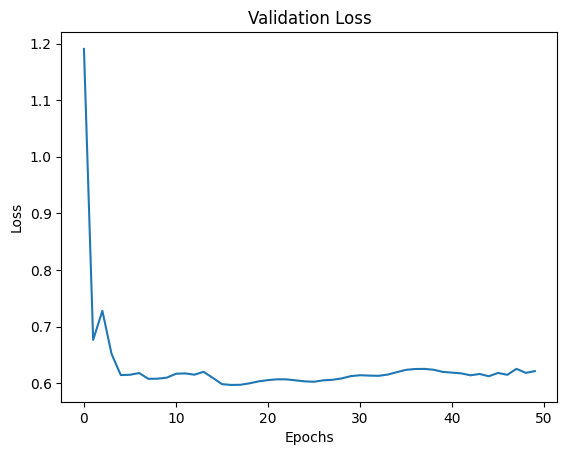

In [59]:
train_model(model, optimizer, criterion, train_loader, valid_loader, 50)

In [60]:
best_model =  LSTMModel_v1(input_size=input_LSTM, hidden_size=hidden_size, num_layers=layers, output_size=output_LSTM)
best_model.load_state_dict(torch.load('best_model_LSTM.pth'.format(input)))
predictions_n_to_n, actuals_n_to_n = test_model(best_model, test_loader, criterion)

Test Loss: 0.6226


In [83]:
result_prediction_by_month(predictions_n_to_n, actuals_n_to_n)


January
MAE: 0.22
Signe error: +
SMAPE: 0.06
RMSE: 0.41
MAAPE: 0.05

February
MAE: 0.24
Signe error: +
SMAPE: 0.08
RMSE: 0.41
MAAPE: 0.07

March
MAE: 0.29
Signe error: +
SMAPE: 0.08
RMSE: 0.48
MAAPE: 0.07

April
MAE: 0.26
Signe error: +
SMAPE: 0.08
RMSE: 0.46
MAAPE: 0.07

May
MAE: 0.23
Signe error: +
SMAPE: 0.08
RMSE: 0.43
MAAPE: 0.07

June
MAE: 0.25
Signe error: +
SMAPE: 0.08
RMSE: 0.49
MAAPE: 0.07

July
MAE: 0.27
Signe error: +
SMAPE: 0.06
RMSE: 0.47
MAAPE: 0.06

August
MAE: 0.24
Signe error: +
SMAPE: 0.07
RMSE: 0.46
MAAPE: 0.06


In [97]:
result_prediction_by_week(predictions_n_to_n, actuals_n_to_n)


 week 00
MAE: 0.14
MAPE: 0.02
Signe error: +
SMAPE: 0.02
RMSE: 0.21
MAAPE: 0.02

 week 01
MAE: 0.21
Signe error: +
SMAPE: 0.07
RMSE: 0.35
MAAPE: 0.06

 week 02
MAE: 0.24
Signe error: +
SMAPE: 0.07
RMSE: 0.44
MAAPE: 0.06

 week 03
MAE: 0.24
MAPE: 0.05
Signe error: +
SMAPE: 0.05
RMSE: 0.46
MAAPE: 0.05

 week 04
MAE: 0.22
Signe error: +
SMAPE: 0.05
RMSE: 0.44
MAAPE: 0.05

 week 05
MAE: 0.23
Signe error: +
SMAPE: 0.07
RMSE: 0.40
MAAPE: 0.06

 week 06
MAE: 0.27
Signe error: +
SMAPE: 0.08
RMSE: 0.48
MAAPE: 0.08

 week 07
MAE: 0.21
Signe error: +
SMAPE: 0.06
RMSE: 0.37
MAAPE: 0.06

 week 08
MAE: 0.26
Signe error: -
SMAPE: 0.10
RMSE: 0.40
MAAPE: 0.09

 week 09
MAE: 0.36
MAPE: 0.06
Signe error: +
SMAPE: 0.06
RMSE: 0.54
MAAPE: 0.06

 week 10
MAE: 0.28
Signe error: +
SMAPE: 0.06
RMSE: 0.47
MAAPE: 0.06

 week 11
MAE: 0.26
Signe error: +
SMAPE: 0.07
RMSE: 0.42
MAAPE: 0.07

 week 12
MAE: 0.26
Signe error: +
SMAPE: 0.09
RMSE: 0.49
MAAPE: 0.08

 week 13
MAE: 0.27
Signe error: +
SMAPE: 0.09
RMSE: 0.51

In [127]:
result_prediction_by_day(predictions_n_to_n, actuals_n_to_n)


 day 1
MAE: 0.13
MAPE: 0.02
RMSE: 0.21
MAAPE: 0.02

 day 2
MAE: 0.12
MAPE: 0.01
RMSE: 0.20
MAAPE: 0.01

 day 3
MAE: 0.14
MAPE: 0.02
RMSE: 0.21
MAAPE: 0.02

 day 4
MAE: 0.16
MAPE: 0.03
RMSE: 0.21
MAAPE: 0.03

 day 5
MAE: 0.30
Signe error: +
SMAPE: 0.09
RMSE: 0.46
MAAPE: 0.09

 day 6
MAE: 0.21
MAPE: 0.09
RMSE: 0.34
MAAPE: 0.09

 day 7
MAE: 0.25
Signe error: +
SMAPE: 0.17
RMSE: 0.46
MAAPE: 0.14

 day 8
MAE: 0.27
MAPE: 0.06
RMSE: 0.42
MAAPE: 0.05

 day 9
MAE: 0.15
MAPE: 0.02
RMSE: 0.26
MAAPE: 0.02

 day 10
MAE: 0.13
MAPE: 0.02
RMSE: 0.18
MAAPE: 0.02

 day 11
MAE: 0.20
MAPE: 0.02
RMSE: 0.24
MAAPE: 0.02

 day 12
MAE: 0.26
MAPE: 0.06
RMSE: 0.61
MAAPE: 0.05

 day 13
MAE: 0.29
Signe error: -
SMAPE: 0.16
RMSE: 0.60
MAAPE: 0.13

 day 14
MAE: 0.38
Signe error: -
SMAPE: 0.17
RMSE: 0.55
MAAPE: 0.14

 day 15
MAE: 0.26
MAPE: 0.04
RMSE: 0.39
MAAPE: 0.04

 day 16
MAE: 0.16
MAPE: 0.03
RMSE: 0.24
MAAPE: 0.03

 day 17
MAE: 0.15
MAPE: 0.02
RMSE: 0.21
MAAPE: 0.02

 day 18
MAE: 0.18
MAPE: 0.02
RMSE: 0.30
MAA

In [151]:
result_prediction_by_hour(predictions_n_to_n, actuals_n_to_n)


 day: 1 hour: 12
MAE: 0.13
Signe error: +
SMAPE: 0.03
RMSE: 0.15
MAAPE: 0.03

 day: 1 hour: 13
MAE: 0.18
Signe error: +
SMAPE: 0.04
RMSE: 0.19
MAAPE: 0.05

 day: 1 hour: 14
MAE: 0.36
Signe error: -
SMAPE: 0.08
RMSE: 0.51
MAAPE: 0.07

 day: 1 hour: 15
MAE: 0.13
Signe error: +
SMAPE: 0.02
RMSE: 0.28
MAAPE: 0.02

 day: 1 hour: 16
MAE: 0.11
Signe error: -
SMAPE: 0.02
RMSE: 0.27
MAAPE: 0.02

 day: 1 hour: 17
MAE: 0.08
Signe error: -
SMAPE: 0.01
RMSE: 0.09
MAAPE: 0.01

 day: 1 hour: 18
MAE: 0.09
Signe error: -
SMAPE: 0.01
RMSE: 0.09
MAAPE: 0.01

 day: 1 hour: 19
MAE: 0.09
Signe error: -
SMAPE: 0.01
RMSE: 0.09
MAAPE: 0.01

 day: 1 hour: 20
MAE: 0.09
Signe error: -
SMAPE: 0.01
RMSE: 0.09
MAAPE: 0.01

 day: 1 hour: 21
MAE: 0.09
Signe error: -
SMAPE: 0.01
RMSE: 0.09
MAAPE: 0.01

 day: 1 hour: 22
MAE: 0.09
Signe error: -
SMAPE: 0.01
RMSE: 0.09
MAAPE: 0.01

 day: 1 hour: 23
MAE: 0.09
Signe error: -
SMAPE: 0.01
RMSE: 0.09
MAAPE: 0.01

 day: 2 hour: 0
MAE: 0.09
Signe error: -
SMAPE: 0.01
RMSE: 0.09

In [62]:
#result_prediction(predictions, actuals)

##### f(a(t), b(t), c(t)) = a(t+1)

In [63]:
df_weekday_hour_prep.head(3)

station_id,42,60,70
time,,,
2013-08-29 12:05:00,7.0,8.0,0.00
2013-08-29 12:10:00,7.0,8.0,0.00
2013-08-29 12:15:00,7.0,8.5,0.25


In [64]:
# Define the sliding window size and stride
window_size = 3
stride = 1

# Create datasets and data loaders for training, validation, and test sets
train_dataset = TimeSeriesDataset(train_data.values, window_size, stride, drop=[1, 2])
valid_dataset = TimeSeriesDataset(valid_data.values, window_size, stride, drop=[1, 2])
test_dataset = TimeSeriesDataset(test_data.values, window_size, stride, drop=[1, 2])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [65]:
# Parameters of the LSTM
layers = 3
hidden_size = 32
input_LSTM = 3
output_LSTM = 1

# Instantiate your LSTM model and define the loss function and optimizer
model = LSTMModel_v1(input_size=input_LSTM, hidden_size=hidden_size, num_layers=layers, output_size=output_LSTM)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/100, Training Loss: 12250.4889, Validation Loss: 0.3211
Epoch 2/100, Training Loss: 1083.2765, Validation Loss: 0.2257
Epoch 3/100, Training Loss: 769.2518, Validation Loss: 0.2131
Epoch 4/100, Training Loss: 700.4822, Validation Loss: 0.2225
Epoch 5/100, Training Loss: 657.0799, Validation Loss: 0.2200
Epoch 6/100, Training Loss: 636.7472, Validation Loss: 0.1917
Epoch 7/100, Training Loss: 621.3416, Validation Loss: 0.1700
Epoch 8/100, Training Loss: 608.0926, Validation Loss: 0.1658
Epoch 9/100, Training Loss: 597.3337, Validation Loss: 0.1674
Epoch 10/100, Training Loss: 588.0432, Validation Loss: 0.1625
Epoch 11/100, Training Loss: 581.2075, Validation Loss: 0.1577
Epoch 12/100, Training Loss: 575.3957, Validation Loss: 0.1551
Epoch 13/100, Training Loss: 570.5592, Validation Loss: 0.1537
Epoch 14/100, Training Loss: 565.9542, Validation Loss: 0.1526
Epoch 15/100, Training Loss: 562.2236, Validation Loss: 0.1516
Epoch 16/100, Training Loss: 558.9454, Validation Loss: 0.150

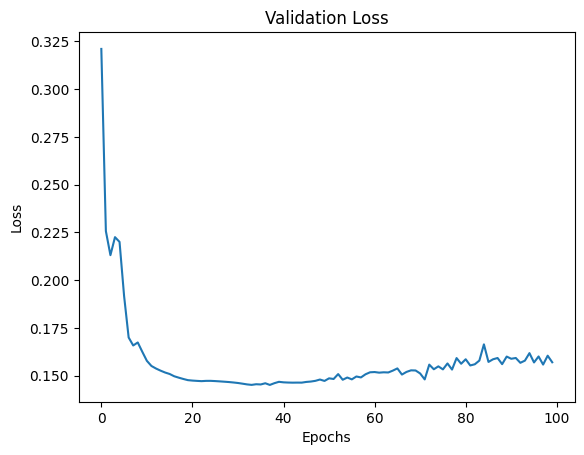

In [66]:
train_model(model, optimizer, criterion, train_loader, valid_loader, 100)

In [67]:
best_model =  LSTMModel_v1(input_size=input_LSTM, hidden_size=32, num_layers=layers, output_size=output_LSTM)
best_model.load_state_dict(torch.load('best_model_LSTM.pth'.format(input)))
predictions, actuals = test_model(best_model, test_loader, criterion)

Test Loss: 0.1716


In [68]:
result_prediction_by_month(predictions, actuals)


January
MAE: 0.15
Signe error: +
SMAPE: 0.04
RMSE: 0.37
MAAPE: 0.04

February
MAE: 0.15
Signe error: +
SMAPE: 0.05
RMSE: 0.36
MAAPE: 0.05

March
MAE: 0.21
Signe error: +
SMAPE: 0.06
RMSE: 0.44
MAAPE: 0.05

April
MAE: 0.20
Signe error: +
SMAPE: 0.06
RMSE: 0.42
MAAPE: 0.06

May
MAE: 0.17
Signe error: +
SMAPE: 0.06
RMSE: 0.39
MAAPE: 0.05

June
MAE: 0.19
Signe error: +
SMAPE: 0.06
RMSE: 0.46
MAAPE: 0.06

July
MAE: 0.20
Signe error: -
SMAPE: 0.05
RMSE: 0.44
MAAPE: 0.04

August
MAE: 0.18
Signe error: -
SMAPE: 0.06
RMSE: 0.42
MAAPE: 0.05


In [ ]:
#result_prediction(predictions, actuals)